# 1 可视化TensorBoard
TensorBoard: TensorFlow中强大的可视化工具\
支持标量、图像、文本、音频、视频和Eembedding等多种数据可视化 \
`如何将服务器中的tensorboard在本地显示?`
```
启动时映射一下端口，将服务器的tensorboard端口6006映射到本地16006端口
ssh -L 16006:127.0.0.1:6006 服务器ip
```
服务器端启动时
```
tesorboard --logdir=./runs --port=6006
```

In [1]:
'''
测试tensorboard是否安装成功
'''
import numpy as np
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(comment = 'test tensorboard')

for x in range(100):
    writer.add_scalar('y=2x', x * 2, x)
    writer.add_scalar('y=pow(2,x)', 2 ** x, x)

    writer.add_scalars('data/scalar_group', {"xsinx": x * np.sin(x),
                                             "xcosx": x * np.cos(x),
                                             "arctanx": np.arctan(x)}, x)
writer.close()

---
## 1.1 标量可视化
### - SummaryWriter
功能：提供创建event file的高级接口
主要属性：
- log_dir: event file 输出文件夹
- comment: 不指定log_dir时，文件夹后缀/与上一个参数不同时出现
- filename_suffix: event file文件名后缀

### - add_scalar()
功能：记录标量
- tag：图像的标签名，图的唯一标识
- scalar_value：要记录的标量(y轴)
- global_step: x轴

### - add_scalars()
- main_tag: 该图的标签
- tag_scalar_dict: key是变量的tag, value是变量的值

### - add_histogram()
功能：统计直方图与多分位折线图
- tag：图像的标签名，图的唯一标识
- values：要统计的参数
- global_step:`y轴`
- bins:取直方图的bins

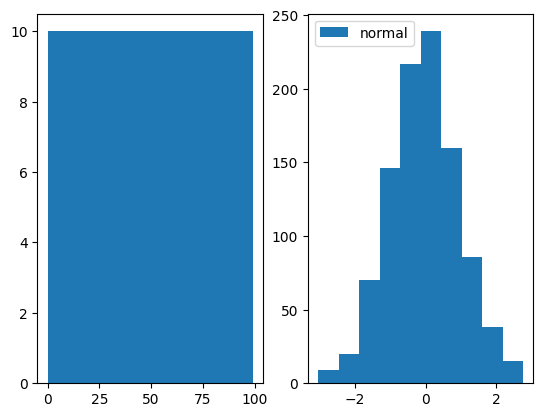

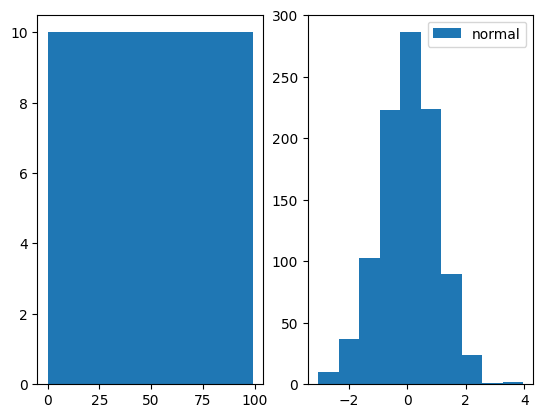

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(comment = 'test_comment', filename_suffix="test_suffix")

for x in range(2):
    np.random.seed(x)

    data_union = np.arange(100)
    data_normal = np.random.normal(size = 1000)

    writer.add_histogram('distribution union', data_union, x)
    writer.add_histogram('distribution normal', data_normal, x)

    plt.subplot(121).hist(data_union, label = "union")
    plt.subplot(122).hist(data_normal, label = "normal")
    plt.legend()
    plt.show()

writer.close()

---
### 应用

In [3]:
import random
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from matplotlib import pyplot as plt
from collections import OrderedDict

random.seed(1)

root_dir = os.getcwd()
# 读哪的数据
dataset_dir = os.path.join(root_dir, "data", "RMB_data")
split_dir = os.path.join(root_dir, "data", "rmb_split")
train_dir = os.path.join(split_dir, "train")
valid_dir = os.path.join(split_dir, "valid")
test_dir = os.path.join(split_dir, "test")

label_name = {"1":0, "100": 1}

class RMBDataset(Dataset):
    # 构造Dataset主要要写的构造函数
    def __init__(self, data_dir, transform = None): 
        '''
        rmb面额分类任务Dataset
        :param data_dir：str, 数据集所在路径
        :param transform: torch.transform, 数据预处理
        '''
        self.label_name = {"1": 0, "100": 1}
        self.data_info = self.get_img_info(data_dir)
        self.transform = transform

    # 主要要写的，接受一个索引返回一个样本, 需要转换成RGB后的图片和标签
    def __getitem__(self, index): 
        path_img, label = self.data_info[index]
        img = Image.open(path_img).convert('RGB') # 0~255

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.data_info)

    @staticmethod
    def get_img_info(data_dir):
        data_info = list()
        for root, dirs, _ in os.walk(data_dir):
            #遍历类别
            for sub_dir in dirs:
                img_names = os.listdir(os.path.join(root, sub_dir))
                img_names = list(filter(lambda x: x.endswith(".jpg"), img_names))

                #遍历图片
                for i in range(len(img_names)):
                    img_name = img_names[i]
                    path_img = os.path.join(root, sub_dir, img_name)
                    label = label_name[sub_dir]
                    data_info.append((path_img, int(label)))
                                     
        return data_info

def set_seed(seed = 1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed()

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    
    transforms.Resize((32, 32)),  # 将图像缩放到 (32 x 32)大小
    transforms.RandomCrop(32, padding = 4), # 对图像进行随机裁剪
    transforms.ToTensor(),  # 将图像转换成张量，同时对像素值进行归一化，从0~255 -> 0~1
    transforms.Normalize(norm_mean, norm_std), # 数据标准化
])

valid_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

# 构建MyDataset实例
train_data = RMBDataset(data_dir = train_dir, transform = train_transform)
valid_data = RMBDataset(data_dir = valid_dir, transform = valid_transform)

class LeNet(nn.Module):
    def __init__(self, classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(OrderedDict({
            'conv1': nn.Conv2d(3, 6, 5),
            'relu1': nn.ReLU(),
            'pool1': nn.MaxPool2d(kernel_size = 2, stride = 2), 
            'conv2': nn.Conv2d(6, 16, 5),
            'relu2': nn.ReLU(),
            'pool2': nn.MaxPool2d(kernel_size = 2, stride = 2),
        }))

        self.classifier = nn.Sequential(OrderedDict({
            'fc1': nn.Linear(16*5*5, 120),
            'relu3': nn.ReLU(),
            'fc2': nn.Linear(120, 84),
            'relu4': nn.ReLU(),
            'fc3': nn.Linear(84, classes),
        }))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, 0, 0.1)
                m.bias.data.zero_()

MAX_EPOCH = 10
BATCH_SIZE = 16
LR = 0.01
log_interval = 10 #日志打印间隔
val_interval = 1

# -------------------导入数据-------------------- #
train_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(dataset = valid_data, batch_size = BATCH_SIZE)

# -------------------构建模型-------------------- #
net = LeNet(classes = 2)
net.initialize_weights()

# -------------------损失函数-------------------- #
criterion = nn.CrossEntropyLoss()

# -------------------优化器---------------------- #
optimizer = optim.SGD(net.parameters(), lr = LR, momentum = 0.9)  # 选择优化器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 10) # 设置学习率下降策略

In [4]:
writer = SummaryWriter(comment = 'test_your_commmet', filename_suffix = "_test_your_filename_suffix")

Training:Epoch[000/010] Iteration[010/011] Loss: 0.6391 Acc:64.38%
Valid:	 Epoch[000/010] Iteration[002/002] Loss: 1.2537 Acc:65.00%
Training:Epoch[001/010] Iteration[010/011] Loss: 0.4283 Acc:81.88%
Valid:	 Epoch[001/010] Iteration[002/002] Loss: 0.1134 Acc:100.00%
Training:Epoch[002/010] Iteration[010/011] Loss: 0.1156 Acc:96.25%
Valid:	 Epoch[002/010] Iteration[002/002] Loss: 0.0064 Acc:100.00%
Training:Epoch[003/010] Iteration[010/011] Loss: 0.0373 Acc:98.75%
Valid:	 Epoch[003/010] Iteration[002/002] Loss: 0.0024 Acc:100.00%
Training:Epoch[004/010] Iteration[010/011] Loss: 0.0049 Acc:100.00%
Valid:	 Epoch[004/010] Iteration[002/002] Loss: 0.0001 Acc:100.00%
Training:Epoch[005/010] Iteration[010/011] Loss: 0.0054 Acc:99.38%
Valid:	 Epoch[005/010] Iteration[002/002] Loss: 0.0000 Acc:100.00%
Training:Epoch[006/010] Iteration[010/011] Loss: 0.0003 Acc:100.00%
Valid:	 Epoch[006/010] Iteration[002/002] Loss: 0.0000 Acc:100.00%
Training:Epoch[007/010] Iteration[010/011] Loss: 0.0546 Acc:9

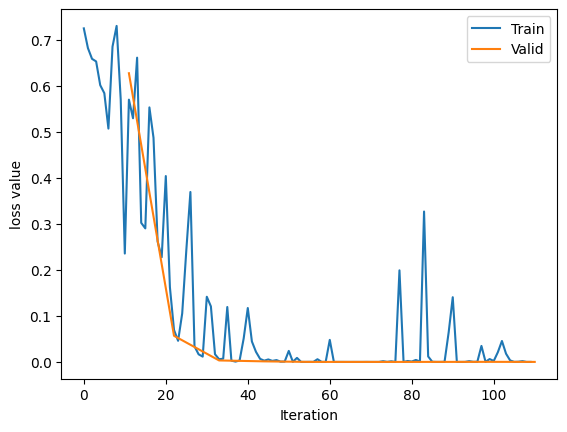

In [5]:
# -------------------训练----------------------- #
train_curve = list()
valid_curve = list()

iter_count = 0
for epoch in range(MAX_EPOCH):

    loss_mean = 0.
    correct = 0.
    total = 0.
    
    net.train()
    for i, data in enumerate(train_loader):

        iter_count += 1
        # forward
        inputs, labels = data
        outputs = net(inputs)

        # backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()

        # update weights
        optimizer.step()

        # 统计分类情况
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().numpy()

        # 打印训练信息
        loss_mean += loss.item()
        train_curve.append(loss.item())
        if (i+1) % log_interval == 0:
            loss_mean = loss_mean / log_interval
            print("Training:Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, i+1, len(train_loader), loss_mean, correct / total))
            loss_mean = 0.

        # 记录数据保存于event file
        writer.add_scalars("loss", {"Train": loss.item()}, iter_count)
        writer.add_scalars("Accuracy", {"Train": correct / total}, iter_count)

    # 记录每个epoch的梯度和权值
    for name, param in net.named_parameters():
        writer.add_histogram(name + '_grad', param.grad, epoch)
        writer.add_histogram(name + '_data', param, epoch)

    scheduler.step()  # 更新学习率

    # validate the model
    if (epoch+1) % val_interval == 0:

        correct_val = 0.
        total_val = 0.
        loss_val = 0.
        net.eval()
        with torch.no_grad():
            for j, data in enumerate(valid_loader):
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).squeeze().sum().numpy()

                loss_val += loss.item()

            valid_curve.append(loss_val/valid_loader.__len__())
            print("Valid:\t Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch, MAX_EPOCH, j+1, len(valid_loader), loss_val, correct_val / total_val))

            # 记录数据，保存于event file
            writer.add_scalars("Loss", {"Valid": np.mean(valid_curve)}, iter_count)
            writer.add_scalars("Accuracy", {"Valid": correct_val / total_val}, iter_count)

train_x = range(len(train_curve))
train_y = train_curve

train_iters = len(train_loader)
valid_x = np.arange(1, len(valid_curve) + 1) * train_iters * val_interval
valid_y = valid_curve

plt.plot(train_x, train_y, label = 'Train')
plt.plot(valid_x, valid_y, label = 'Valid')

plt.legend(loc = 'upper right')
plt.ylabel('loss value')
plt.xlabel('Iteration')
plt.show()

In [12]:
class RMBDataset(Dataset):
    # 构造Dataset主要要写的构造函数
    def __init__(self, data_dir, transform = None): 
        '''
        rmb面额分类任务Dataset
        :param data_dir：str, 数据集所在路径
        :param transform: torch.transform, 数据预处理
        '''
        self.label_name = {"1": 0, "100": 1}
        self.data_info = self.get_img_info(data_dir)
        self.transform = transform

    # 主要要写的，接受一个索引返回一个样本, 需要转换成RGB后的图片和标签
    def __getitem__(self, index): 
        path_img, label = self.data_info[index]
        img = Image.open(path_img).convert('RGB') # 0~255

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.data_info)

    @staticmethod
    def get_img_info(data_dir):
        data_info = list()
        for root, dirs, _ in os.walk(data_dir):
            #遍历类别
            for sub_dir in dirs:
                img_names = os.listdir(os.path.join(root, sub_dir))
                img_names = list(filter(lambda x: x.endswith(".jpg"), img_names))

                #遍历图片
                for i in range(len(img_names)):
                    img_name = img_names[i]
                    path_img = os.path.join(root, sub_dir, img_name)
                    label = label_name[sub_dir]
                    data_info.append((path_img, int(label)))
                                     
        return data_info

---
## 1.2 图像可视化
### - add_image()
功能：记录图像
- tag:图像的标签名，图的唯一标识
- img_tensor: 图像数据，注意尺度
- global_step: x轴
- dataformats: 数据形式，CHW, HWC, HW, defauts = 'CHW'
### - torchvision.utils.make_grid
功能：制作网格图像
- tensor: 图像数据，B\*C\*H\*W形式
- nrow: 行数(列数自动计算)
- padding: 图像间距（像素单位）
- normalize: 是否将像素值标准化（是否为0~255之间，已经是了不用标准化，否则需要标准化）
- range: 标准化范围 （设置关心的像素值范围）
- scale_each: 是否单张图维度标准化
- pad_value: padding的像素值

In [14]:
from torchvision import utils as vutils
writer = SummaryWriter(comment = 'test_your_comment', filename_suffix="_test_your_fs")
transform_compose = transforms.Compose([
    transforms.Resize((32, 64)),
    transforms.ToTensor(),
])
root_dir = os.getcwd()

split_dir = os.path.join(root_dir, "data", "rmb_split")
train_dir = os.path.join(split_dir, "train")

train_data = RMBDataset(data_dir = train_dir, transform = transform_compose)
train_loader = DataLoader(dataset = train_data, batch_size = 16, shuffle = True)
data_batch, label_batch = next(iter(train_loader))

img_grid = vutils.make_grid(data_batch, nrow=4, normalize = False, scale_each = False)
writer.add_image("input img", img_grid, 0)

writer.close()

## 1.3 可视化卷积核

In [19]:
import torchvision.models as model
from torchvision import utils as vutils
writer = SummaryWriter(comment = 'test_your_comment', filename_suffix="_test_your_fs")

alexnet = model.alexnet(pretrained = True)

kernel_num = -1 # 当前获取卷积核的数量
vis_max= 1 # 最大可视化数量

for sub_module in alexnet.modules():
    if isinstance(sub_module, nn.Conv2d):
        kernel_num += 1
        if kernel_num > vis_max:
            break

        kernels = sub_module.weight
        c_out, c_in, k_w, k_h = tuple(kernels.shape)
    
        for o_idx in range(c_out):
            kernel_idx = kernels[o_idx, :, :, :].unsqueeze(1) # make_grid需要BCHW，这里扩展C维度
            kernel_grid = vutils.make_grid(kernel_idx, nrow = c_in, normalize = True, scale_each = True)
            writer.add_image('{} Conv split_in_channel'.format(kernel_num), kernel_grid, global_step = o_idx)
    
        kernel_all = kernels.view(-1, 3, k_h, k_w) # 3, h, w
        kernel_grid = vutils.make_grid(kernel_all, nrow = 8, normalize = True, scale_each = True) # c, h, w

        print("{} Conv shape: {}".format(kernel_num, tuple(kernels.shape)))

writer.close()

0 Conv shape: (64, 3, 11, 11)
1 Conv shape: (192, 64, 5, 5)


## 1.4 可视化特征图

In [24]:
import torchvision.models as models
writer = SummaryWriter(comment='test_your_comment', filename_suffix="_test_your_filename_suffix")

# 数据
path_img = "./data/lena.png"     # your path to image
normMean = [0.49139968, 0.48215827, 0.44653124]
normStd = [0.24703233, 0.24348505, 0.26158768]

img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(normMean, normStd)
])

img_pil = Image.open(path_img).convert('RGB')
if img_transforms is not None:
    img_tensor = img_transforms(img_pil)
img_tensor.unsqueeze_(0)    # chw --> bchw

# 模型
alexnet = models.alexnet(pretrained=True)

# forward
convlayer1 = alexnet.features[0]
fmap_1 = convlayer1(img_tensor)

# 预处理
fmap_1.transpose_(0, 1)  # bchw=(1, 64, 55, 55) --> (64, 1, 55, 55)
fmap_1_grid = vutils.make_grid(fmap_1, normalize=True, scale_each=True, nrow=8)

writer.add_image('feature map in conv1', fmap_1_grid, global_step=322)
writer.close()

In [ ]:
## 1.5 可视化模型计算图
### - add_graph()
功能：可视化模型计算图
- model: 模型，必须是nn.Module
- input_to_model: 输出给模型的数据
- verbose: 是否打印计算图结构 信息

In [27]:
writer = SummaryWriter(comment='test_your_comment', filename_suffix="_test_your_filename_suffix")

# 模型
fake_img = torch.randn(1, 3, 32, 32)

lenet = LeNet(classes=2)

writer.add_graph(lenet, fake_img)

writer.close()


### - torchsummary
功能：查看模型信息，便于调试
- model：pytorch模型
- input_size: 模型输入size
- batch_size: batch size
- device: "cuda" or "cpu"

In [29]:
from torchsummary import summary
print(summary(lenet, (3, 32, 32), device = "cpu"))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                    [-1, 2]             170
Total params: 61,326
Trainable params: 61,326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

---
# 2 Hook函数与CAM算法
## Hook函数
Hook函数机制：不改变主体，实现额外功能，像一个挂件，挂钩，hook\
`注意:针对hook的设置在全连接层和卷积层是不同的`\
Linear layers: grad_input = (db, dr, dw) #bais的梯度，流到下一层的梯度，权重的梯度\
Convolution layers: grad_input = (dr, dw, db)
### - Tensor.register_hook
功能：注册一个反向传播hook函数
Hook函数仅一个输入参数，为张量的梯度 

In [6]:
import torch
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)
a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)

a_grad = list()

def grad_hook(grad): # 定义一个hook函数，用列表存a的梯度
    a_grad.append(grad)

handle = a.register_hook(grad_hook) #给a张量注册hook函数

y.backward()

# 查看梯度
print("gradient:", w.grad, x.grad, a.grad, b.grad, y.grad)
print("a_grad[0]: ", a_grad[0])
handle.remove()

gradient: tensor([5.]) tensor([2.]) None None None
a_grad[0]:  tensor([2.])


C:\Users\asushiro\AppData\Local\Temp\ipykernel_10444\116247183.py:18: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  print("gradient:", w.grad, x.grad, a.grad, b.grad, y.grad)


### - Module.reigster_forward_hook
功能：注册module的前向传播hook函数
参数：
- module：当前网络层
- input：当前网络层输入数据
- output：当前网络层输出数据
### - Module.register_forward_pre_hook
功能：注册module前向传播前的hook函数
参数：
- module：当前网络层
- input：当前网络层输入数据
### - Module.register_backward_hook
功能：注册module反向传播的hook函数
参数：
- module：当前网络层
- grad_input: 当前网络层输入梯度数据
- grad_output:当前网络层输出梯度数据

In [7]:
import torch.nn as nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        return x

def forward_hook(module, data_input, data_output):
    fmap_block.append(data_output)
    input_block.append(data_input)

def forward_pre_hook(module, data_input):
    print("forward_pre_hook input:{}".format(data_input))

def backward_hook(module, grad_input, grad_output):
    print("backward hook input:{}".format(grad_input))
    print("backward hook output:{}".format(grad_output))

# 初始化网络
net = Net()
net.conv1.weight[0].detach().fill_(1)
net.conv1.weight[1].detach().fill_(2)
net.conv1.bias.data.detach().zero_()

# 注册hook
fmap_block = list()
input_block = list()
net.conv1.register_forward_hook(forward_hook)
net.conv1.register_forward_pre_hook(forward_pre_hook)
net.conv1.register_backward_hook(backward_hook)

# inference
fake_img = torch.ones((1, 1, 4, 4))   # batch size * channel * H * W
output = net(fake_img)

loss_fnc = nn.L1Loss()
target = torch.randn_like(output)
loss = loss_fnc(target, output)
loss.backward()

# 观察
# print("output shape: {}\noutput value: {}\n".format(output.shape, output))
# print("feature maps shape: {}\noutput value: {}\n".format(fmap_block[0].shape, fmap_block[0]))
# print("input shape: {}\ninput value: {}".format(input_block[0][0].shape, input_block[0]))

forward_pre_hook input:(tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]]),)
backward hook input:(None, tensor([[[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]]],


        [[[0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000]]]]), tensor([0.5000, 0.5000]))
backward hook output:(tensor([[[[0.5000, 0.0000],
          [0.0000, 0.0000]],

         [[0.5000, 0.0000],
          [0.0000, 0.0000]]]]),)


D:\Code Software\MinicondaEnv\myenv\lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


### 利用hook函数获取网络中的特征图，并将其可视化

In [9]:
import torch.nn as nn
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models

# ----------------------------------- feature map visualization -----------------------------------
writer = SummaryWriter(comment='test_your_comment', filename_suffix="_test_your_filename_suffix")

# 数据
path_img = "./data/lena.png"     # your path to image
normMean = [0.49139968, 0.48215827, 0.44653124]
normStd = [0.24703233, 0.24348505, 0.26158768]

img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(normMean, normStd),
])

img_pil = Image.open(path_img).convert('RGB')
if img_transforms is not None:
    img_tensor = img_transforms(img_pil)
img_tensor.unsqueeze_(0)    # chw --> bchw

# 模型
alexnet = models.alexnet(pretrained=True)

# 注册hook
fmap_dict = dict()
for name, sub_module in alexnet.named_modules():

    if isinstance(sub_module, nn.Conv2d):
        key_name = str(sub_module.weight.shape)
        fmap_dict.setdefault(key_name, list())

        n1, n2 = name.split(".")

        def hook_func(m, i, o):
            key_name = str(m.weight.shape)
            fmap_dict[key_name].append(o)

        alexnet._modules[n1]._modules[n2].register_forward_hook(hook_func)

# forward
output = alexnet(img_tensor)

# add image
for layer_name, fmap_list in fmap_dict.items():
    fmap = fmap_list[0]
    fmap.transpose_(0, 1)

    nrow = int(np.sqrt(fmap.shape[0]))
    fmap_grid = vutils.make_grid(fmap, normalize=True, scale_each=True, nrow=nrow)
    writer.add_image('feature map in {}'.format(layer_name), fmap_grid, global_step=322)

D:\Code Software\MinicondaEnv\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Code Software\MinicondaEnv\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## CAM
CAM：类激活图，class activation map\
缺点：需要改动神经网络的最后一层的结构，添加global average pool层在进行训练

因此提出改进：\
Grad-CAM:CAM改进版，利用梯度作为特征图权重

可以用来检查神经网络学习到的特征是否是好的\
[具体学习文章](https://zhuanlan.zhihu.com/p/75894080)